In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from qiskit.opflow import Zero, One, I, X, Y, Z
from qiskit.circuit import Parameter, ParameterVector
plt.rcParams.update({"font.size": 16})  # enlarge matplotlib fonts

In [ ]:
from qiskit_nature.operators.second_quantization import FermionicOp
from qiskit_nature.mappers.second_quantization import JordanWignerMapper

def compute_H_secondquant(eps, t, tc, delta, num_sites):
    second_quant_H = 0
    for i in range(num_sites):
        second_quant_H += eps[i] * ( FermionicOp("+_{}".format(i)) @ FermionicOp("-_{}".format(i)) )
        # second_quant_H -= eps[i] * ( FermionicOp("+_{}".format(i)) @ FermionicOp("-_{}".format(i)) )
        # second_quant_H += eps[i] * 1/2

    second_quant_H += t[0]*(FermionicOp("+_{}".format(0)) @ FermionicOp("-_{}".format(1)))
    second_quant_H += np.conjugate(t[0])*(FermionicOp("+_{}".format(1)) @ FermionicOp("-_{}".format(0)))

    second_quant_H += delta[0]*(FermionicOp("+_{}".format(0)) @ FermionicOp("+_{}".format(1)))
    second_quant_H += np.conjugate(delta[0])*(FermionicOp("-_{}".format(1)) @ FermionicOp("-_{}".format(0)) )

    second_quant_H += t[1]*(FermionicOp("+_{}".format(2)) @ FermionicOp("-_{}".format(3)))
    second_quant_H += np.conjugate(t[1])*(FermionicOp("+_{}".format(3)) @ FermionicOp("-_{}".format(2)))

    second_quant_H += delta[1]*(FermionicOp("+_{}".format(2)) @ FermionicOp("+_{}".format(3)))
    second_quant_H += np.conjugate(delta[1])*(FermionicOp("-_{}".format(3)) @ FermionicOp("-_{}".format(2)) )

    second_quant_H += tc*(FermionicOp("+_{}".format(1)) @ FermionicOp("-_{}".format(2)) + FermionicOp("+_{}".format(2)) @ FermionicOp("-_{}".format(1)) )
        #Check the code for this
    # Transform to Pauli Operators
    # jw_mapper = JordanWignerMapper
    # pauli_H = JordanWignerMapper.map(jw_mapper, second_quant_H)

    return second_quant_H

compute_H_secondquant(np.ones(4),  [1, 1], 0.5, [1, 1], 4).to_matrix()

<16x16 sparse matrix of type '<class 'numpy.complex128'>'
	with 55 stored elements in Compressed Sparse Column format>

In [35]:
from qiskit_nature.operators.second_quantization import FermionicOp
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import JordanWignerMapper

def compute_H_qubit(eps, t, tc, delta, num_sites):
    # start from a “zero” FermionicOp
    second_quant_H = FermionicOp([], register_length=num_sites)

    # build number terms with the −½ shift
    for i in range(num_sites):
        num_op = (FermionicOp(f"+_{i}", register_length=num_sites) @ FermionicOp(f"-_{i}", register_length=num_sites) - FermionicOp(f"-_{i}", register_length=num_sites) @ FermionicOp(f"+_{i}", register_length=num_sites))
        # the commutator form n_i - (1 - n_i) = 2 n_i - 1
        second_quant_H += eps[i] * (num_op - 0.5 * FermionicOp([("", 1.0)], register_length=num_sites))

    # hoppings & pairings (unchanged)
    second_quant_H += t[0] * (FermionicOp("+_0", register_length=num_sites)
                             @ FermionicOp("-_1", register_length=num_sites))
    second_quant_H += np.conjugate(t[0]) * (FermionicOp("+_1", register_length=num_sites)
                                           @ FermionicOp("-_0", register_length=num_sites))
    second_quant_H += delta[0] * (FermionicOp("+_0", register_length=num_sites)
                                 @ FermionicOp("+_1", register_length=num_sites))
    second_quant_H += np.conjugate(delta[0]) * (FermionicOp("-_1", register_length=num_sites)
                                               @ FermionicOp("-_0", register_length=num_sites))
    second_quant_H += t[1] * (FermionicOp("+_2", register_length=num_sites)
                             @ FermionicOp("-_3", register_length=num_sites))
    second_quant_H += np.conjugate(t[1]) * (FermionicOp("+_3", register_length=num_sites)
                                           @ FermionicOp("-_2", register_length=num_sites))
    second_quant_H += delta[1] * (FermionicOp("+_2", register_length=num_sites)
                                 @ FermionicOp("+_3", register_length=num_sites))
    second_quant_H += np.conjugate(delta[1]) * (FermionicOp("-_3", register_length=num_sites)
                                               @ FermionicOp("-_2", register_length=num_sites))
    second_quant_H += tc * (
        FermionicOp("+_1", register_length=num_sites) @ FermionicOp("-_2", register_length=num_sites)
      + FermionicOp("+_2", register_length=num_sites) @ FermionicOp("-_1", register_length=num_sites)
    )

    # map to qubits
    converter = QubitConverter(JordanWignerMapper())
    return converter.convert(second_quant_H)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, Markdown

def hamiltonian(epsilon1, epsilon2, t, Delta):
    return np.array([[ epsilon1,   t,       0,    Delta],
                     [      t, epsilon2,   -Delta,    0],
                     [       0,   -Delta, -epsilon1,    -t],
                     [    Delta,      0,      -t, -epsilon2]])

def compute_eigensystem(epsilon1, epsilon2, t, Delta):
    H = hamiltonian(epsilon1, epsilon2, t, Delta)
    eigvals, eigvecs = np.linalg.eig(H)
    idx = np.argsort(eigvals)  # Sort eigenvalues and vectors
    return np.real(eigvals[idx]), np.real(eigvecs[:, idx])

def plot_energy_vs_epsilon(t, Delta):
    plt.close('all')  # Close previous figures to avoid duplicate plots

    epsilon_vals = np.linspace(-5, 5, 400)
    bands = [compute_eigensystem(eps, eps, t, Delta)[0] for eps in epsilon_vals]
    bands = np.array(bands)

    plt.figure(figsize=(8, 6))
    for i in range(bands.shape[1]):
        plt.plot(epsilon_vals, bands[:, i], label=rf'$E_{{{i+1}}}$')

    # Add t and Δ to legend
    plt.plot([], [], ' ', label=f't = {t}')
    plt.plot([], [], ' ', label=f'Δ = {Delta}')
    
    plt.xlabel(r'$\varepsilon$')
    plt.ylabel('Energy')
    plt.title(r'Eigen Energies vs. $\varepsilon$')
    plt.legend()
    plt.grid(True)

    global current_fig
    current_fig = plt.gcf()  # Store the latest figure
    plt.show()

    # Compute and display the eigenvectors for ε = 0
    eps0 = 0  # Chosen value to display eigenvectors
    eigvals, eigvecs = compute_eigensystem(eps0, eps0, t, Delta)
    
    eigvec_str = "### Eigenvectors at \( \varepsilon_1 = \varepsilon_2 = 0 \):\n"
    for i in range(4):
        eigvec_str += f"**Eigenvalue {eigvals[i]:.3f}:**  \n"
        eigvec_str += f"[{', '.join(f'{v:.3f}' for v in eigvecs[:, i])}]\n\n"

    display(Markdown(eigvec_str))  # Display nicely formatted eigenvectors

# Sliders for t and Δ
t_slider = widgets.FloatSlider(min=-5.0, max=5.0, step=1.0, value=1.0, description='t')
Delta_slider = widgets.FloatSlider(min=-5.0, max=5.0, step=1.0, value=1.0, description="Δ")

# Save button
save_button = widgets.Button(description="Save Figure")

def save_figure(_):
    if current_fig:
        filename = f"plot_t={t_slider.value}_Delta={Delta_slider.value}.pdf"
        current_fig.savefig(filename, dpi=300)
        print(f"Figure saved as {filename}")

save_button.on_click(save_figure)

# Display the interactive widgets
display(widgets.VBox([t_slider, Delta_slider, save_button]))
interactive_plot = widgets.interactive_output(plot_energy_vs_epsilon, {'t': t_slider, 'Delta': Delta_slider})
display(interactive_plot)



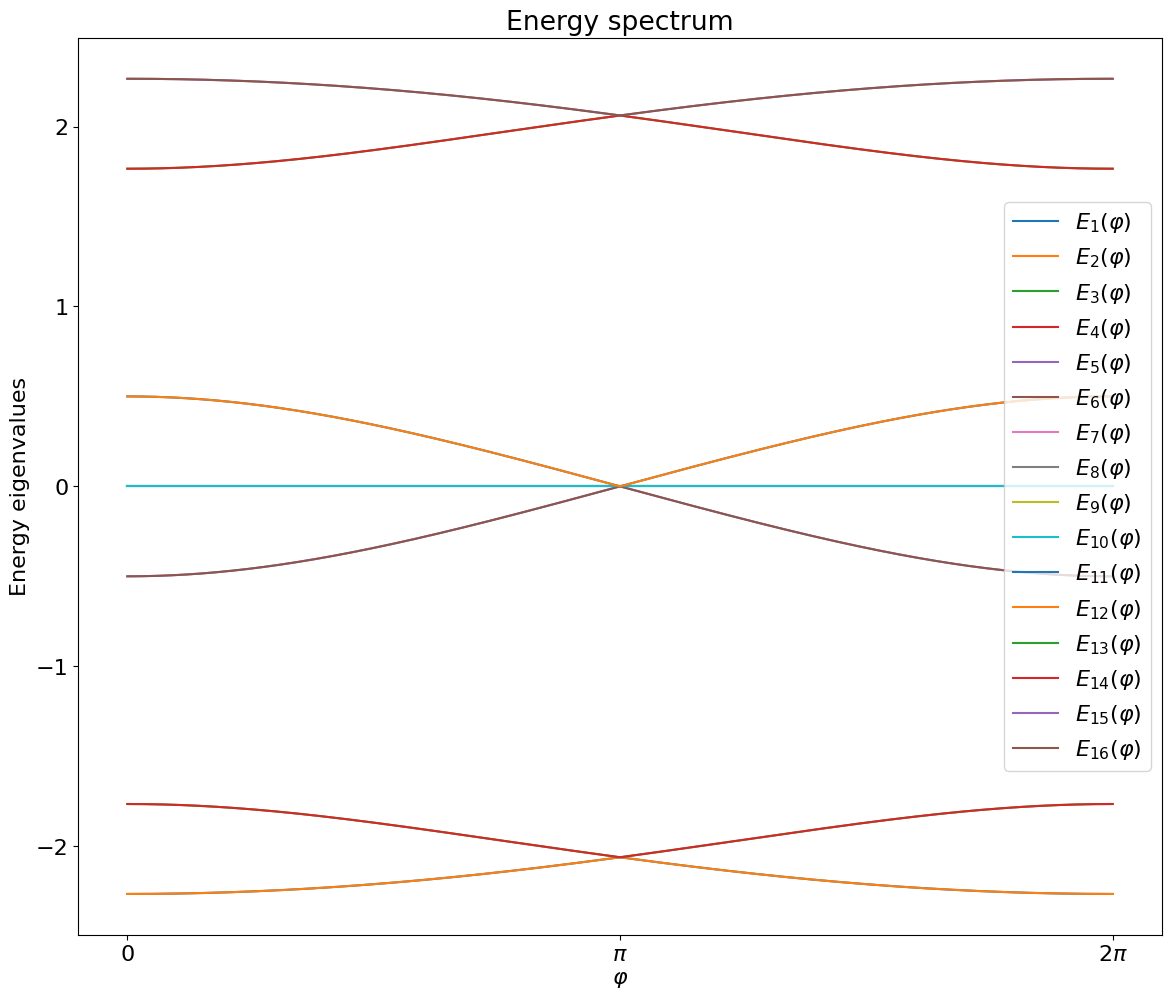

In [ ]:
num_sites = 4  # total number of sites/qubits
# Define parameters

# Numerical values for on-site energies and tunneling
eps = np.zeros(num_sites)  # ε_i = 1 for all sites
tc  = 0.5                # central coupling strength

# Sweep phi from 0 to 6π
phi_list = np.linspace(0, 2*np.pi, 1000)
# Array to store the two lowest eigenvalues
n = 16
levels = np.zeros((len(phi_list), n))

# Loop over phi values, bind parameters, diagonalize, and store lowest two levels
for i, phi in enumerate(phi_list):
    # pairing phases
    delta0 = np.exp(-1j * phi / 2)
    delta1 = np.exp(+1j * phi / 2)
    t0 = delta0
    t1 = delta1

    # get numeric Hamiltonian and eigenvalues
    jw_h = compute_H_qubit(eps, [t0, t1], tc, [delta0, delta1], num_sites)
    H_num = jw_h.to_matrix()                    # now this is a (16×16) numpy array
    eigs  = np.linalg.eigvalsh(H_num)       
    # save two lowest levels
    # select the 4 eigenvalues nearest to zero (smallest |E|)

    selected = np.argsort(np.abs(eigs))[:4]
    # sort these so plotting is ordered from lowest to highest
    levels[i, :] = eigs#eigs[5:11]#eigs[selected]

# Plot the selected energy levels vs varphi
plt.figure(figsize=(12,10))
for j in range(n):
    plt.plot(phi_list, levels[:, j], label=fr'$E_{{{j+1}}}(\varphi)$')

# Label x-axis with varphi ticks at multiples of 2π
ticks = [0, np.pi, 2*np.pi]
labels = [r'$0$', r'$\pi$', r'$2\pi$']
plt.xticks(ticks, labels)

plt.xlabel(r'$\varphi$')  # use varphi
plt.ylabel('Energy eigenvalues')
plt.legend()
plt.tight_layout()
plt.title(r'Energy spectrum at sweet spot')
plt.savefig("figures/energy/spectrum02pi_sweet_spot.pdf")
plt.show()

In [2]:
def compute_H(eps, t, tc, delta, num_sites):
    # start from a single‐qubit identity
    H = 0

    # On-site terms
    for i in range(num_sites):
        H += eps[i] / 2 * ((I ^ num_sites) - ((I ^ (num_sites - i - 1)) ^ Z ^ (I ^ i)))
        #H += eps[i] / 2 * ((I ^ num_sites))
    # Coupling term (qubits 2 and 1)
    H += tc / 2 * ((I ^ X ^ X ^ I) + (I ^ Y ^ Y ^ I))
    # Left tunneling (qubits 3 and 2)
    H += t[0]/4 * (
        (I ^ I ^ X ^ X) + 1j * (I ^ I ^ Y ^ X) - 1j * (I ^ I ^ X ^ Y) + (I ^ I ^ Y ^ Y)
    )
    H += np.conjugate(t[0])/4 * (
        (I ^ I ^ X ^ X) - 1j * (I ^ I ^ Y ^ X) + 1j * (I ^ I ^ X ^ Y) + (I ^ I ^ Y ^ Y)
    )

    # Left pairing
    H += delta[0]/4 * (
        (I ^ I ^ X ^ X) - 1j * (I ^ I ^ Y ^ X) - 1j * (I ^ I ^ X ^ Y) - (I ^ I ^ Y ^ Y)
    )
    H += np.conjugate(delta[0])/4 * (
        (I ^ I ^ X ^ X) + 1j * (I ^ I ^ Y ^ X) + 1j * (I ^ I ^ X ^ Y) - (I ^ I ^ Y ^ Y)
    )

    # Right tunneling (qubits 1 and 0)
    H += t[1]/4 * (
        (X ^ X ^ I ^ I) + 1j * (Y ^ X ^ I ^ I) - 1j * (X ^ Y ^ I ^ I) + (Y ^ Y ^ I ^ I)
    )
    H += np.conjugate(t[1])/4 * (
        (X ^ X ^ I ^ I) - 1j * (Y ^ X ^ I ^ I) + 1j * (X ^ Y ^ I ^ I) + (Y ^ Y ^ I ^ I)
    )

    # Right pairing
    H += delta[1]/4 * (
        (X ^ X ^ I ^ I) - 1j * (Y ^ X ^ I ^ I) - 1j * (X ^ Y ^ I ^ I) - (Y ^ Y ^ I ^ I)
    )
    H += np.conjugate(delta[1])/4 * (
        (X ^ X ^ I ^ I) + 1j * (Y ^ X ^ I ^ I) + 1j * (X ^ Y ^ I ^ I) - (Y ^ Y ^ I ^ I)
    )

    return H



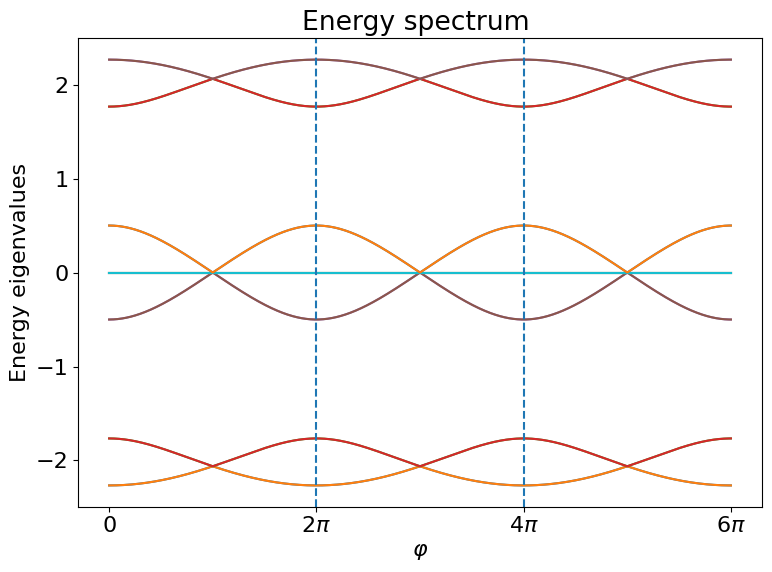

In [3]:
num_sites = 4  # total number of sites/qubits
# Define parameters
eps_param   = ParameterVector("eps", num_sites)
delta_param = ParameterVector("delta", 2)
t_param     = ParameterVector("t", 2)
tc_param    = Parameter("tc")
# Build symbolic Hamiltonian
H_param     = compute_H(eps_param, t_param, tc_param, delta_param, num_sites)

# Numerical values for on-site energies and tunneling
eps = np.zeros(num_sites)  # ε_i = 1 for all sites
tc  = 0.5                # central coupling strength

# Sweep phi from 0 to 6π
phi_list = np.linspace(0, 6*np.pi, 1000)
# Array to store the two lowest eigenvalues
n=16
levels = np.zeros((len(phi_list), n))

# Loop over phi values, bind parameters, diagonalize, and store lowest two levels
for i, phi in enumerate(phi_list):
    # pairing phases
    delta0 = np.exp(-1j * phi / 2)
    delta1 = np.exp(+1j * phi / 2)
    t0 = delta0
    t1 = delta1

    # create mapping from symbolic parameters to numeric values
    bind_map = {eps_param[j]: eps[j] for j in range(num_sites)}
    bind_map.update({t_param[0]: t0, t_param[1]: t1})
    bind_map.update({delta_param[0]: delta0, delta_param[1]: delta1})
    bind_map[tc_param] = tc

    # get numeric Hamiltonian and eigenvalues
    H_num = H_param.bind_parameters(bind_map).to_matrix()
    eigs  = np.linalg.eigvalsh(H_num)
    # save two lowest levels
    # select the 4 eigenvalues nearest to zero (smallest |E|)
    selected = np.argsort(np.abs(eigs))[:4]
    # sort these so plotting is ordered from lowest to highest
    levels[i, :] = eigs#eigs[5:11]#eigs[selected]

# Plot the selected energy levels vs varphi
plt.figure(figsize=(8,6))
for j in range(n):
    plt.plot(phi_list, levels[:, j], label=fr'$E_{{{j+1}}}(\varphi)$')

# Add vertical dashed lines at multiples of 2π
for k in range(1, 3):
    plt.axvline(2 * np.pi * k, linestyle='--')

# Label x-axis with varphi ticks at multiples of 2π
ticks = [0, 2*np.pi, 4*np.pi, 6*np.pi]
labels = [r'$0$', r'$2\pi$', r'$4\pi$', r'$6\pi$']
plt.xticks(ticks, labels)

plt.xlabel(r'$\varphi$')  # use varphi
plt.ylabel('Energy eigenvalues')
#plt.legend()
plt.title(r'Energy spectrum ')
plt.tight_layout()
plt.savefig("figures/energy/spectrum06pi.pdf")
plt.show()

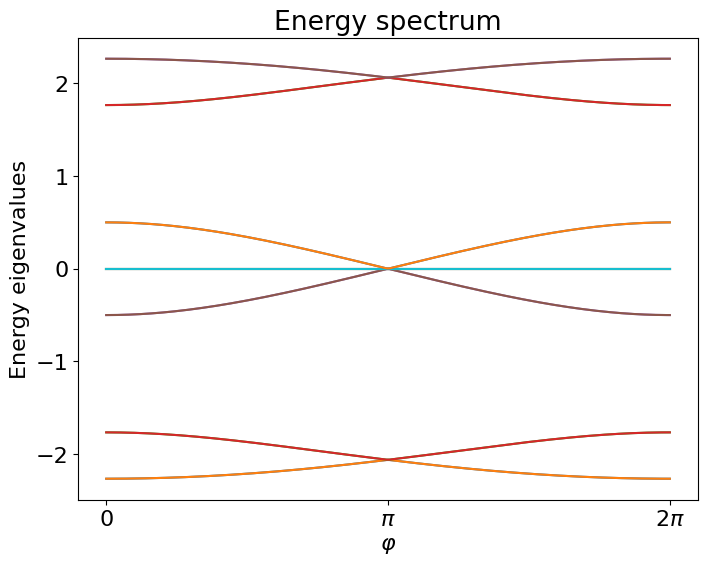

In [39]:
num_sites = 4  # total number of sites/qubits
# Define parameters
eps_param   = ParameterVector("eps", num_sites)
delta_param = ParameterVector("delta", 2)
t_param     = ParameterVector("t", 2)
tc_param    = Parameter("tc")
# Build symbolic Hamiltonian
H_param     = compute_H(eps_param, t_param, tc_param, delta_param, num_sites)

# Numerical values for on-site energies and tunneling
eps = np.zeros(num_sites)  # ε_i = 1 for all sites
tc  = 0.5                # central coupling strength

# Sweep phi from 0 to 6π
phi_list = np.linspace(0, 2*np.pi, 200)
# Array to store the two lowest eigenvalues
n = num_sites**2
levels = np.zeros((len(phi_list), n))

# Loop over phi values, bind parameters, diagonalize, and store lowest two levels
for i, phi in enumerate(phi_list):
    # pairing phases
    delta0 = np.exp(-0.5j * phi)
    delta1 = np.exp(+0.5j * phi)
    t0 = delta0
    t1 = delta1

    # create mapping from symbolic parameters to numeric values
    bind_map = {eps_param[j]: eps[j] for j in range(num_sites)}
    bind_map.update({t_param[0]: t0, t_param[1]: t1})
    bind_map.update({delta_param[0]: delta0, delta_param[1]: delta1})
    bind_map[tc_param] = tc

    # get numeric Hamiltonian and eigenvalues
    H_num = H_param.bind_parameters(bind_map).to_matrix()
    eigs  = np.linalg.eigvalsh(H_num)
    # save two lowest levels
    # select the 4 eigenvalues nearest to zero (smallest |E|)
    selected = np.argsort(np.abs(eigs))[:4]
    # sort these so plotting is ordered from lowest to highest
    levels[i, :] = eigs[:]#eigs[selected]

# Plot the selected energy levels vs varphi
plt.figure(figsize=(8,6))
for j in range(n):
    plt.plot(phi_list, levels[:, j], label=fr'$E_{{{j+1}}}(\varphi)$')

# Label x-axis with varphi ticks at multiples of 2π
ticks = [0, np.pi, 2*np.pi]
labels = [r'$0$', r'$\pi$', r'$2\pi$']
plt.xticks(ticks, labels)

plt.xlabel(r'$\varphi$')  # use varphi
plt.ylabel('Energy eigenvalues')
#plt.legend()
plt.title(r'Energy spectrum')
plt.savefig("figures/energy/spectrum02pi_sweet_spot.pdf")
plt.show()

In [ ]:
# p is our parameter over different initial states
p_vals = np.linspace(0, 1, 20)
energy_matrix = np.zeros((len(p_vals), 2))

# Loop over different p values for initial state preparation
for i, p_val in enumerate(tqdm(p_vals)):
    initial_state = p_val * (Zero ^ Zero ^ Zero ^ Zero) + (1 - p_val) * (One ^ One ^ One ^ One)

    # Compute the trotterized evolution operator using H
    energy = (initial_state.adjoint() @ H @ initial_state).eval()

    energy_matrix[i,0] = p_val
    energy_matrix[i,1] = energy

plt.plot(energy_matrix[:,0],energy_matrix[:,1])
plt.xlabel('p')
plt.ylabel('E')
plt.title(r'Energy for initial states $p|00\rangle + (1-p)|11\rangle$' + '\n' + r'$\varepsilon_1=\varepsilon_2=1$ and $\Delta=t=1$ ')
plt.show

  0%|          | 0/20 [00:00<?, ?it/s]


NameError: name 'H' is not defined